## Initialization

In [1]:
import json
import os
from pycocotools.coco import COCO
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')

In [3]:
# initialize COCO api for instance annotations
coco=COCO('data/benign_data/coco_train.json')
coco_adv = COCO('data/benign_data/coco_only_adv.json')

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


## Instance visualization

In [4]:
def visualize(cocodata, imgIds_logo, figsize):
    # randomly sample an instance
    random_idx = np.random.choice(imgIds_logo, 1)

    # load and display image
    img = cocodata.loadImgs(random_idx)[0]
    print(img['file_name'])
    I = cv2.imread(os.path.join('data/benign_data/benign_database', img['file_name']))
    plt.axis('off')
    plt.figure(figsize=figsize)
    plt.imshow(I)
    plt.show()
    
    # load the corresponding annotation for this image
    annIds = cocodata.getAnnIds(imgIds=img['id'])
    anns = cocodata.loadAnns(annIds)

    for j, inst in enumerate(anns):
        I = cv2.rectangle(I, (inst['bbox'][0], inst['bbox'][1]), 
                          (inst['bbox'][2]+inst['bbox'][0], inst['bbox'][3]+inst['bbox'][1]), 
                          (255, 0, 0), 2)

    plt.axis('off')
    plt.figure(figsize=figsize)
    plt.imshow(I)
    plt.show()

## Summary

In [5]:
# display categories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
box logo



In [6]:
# get all images containing given categories
catIds_logo = coco.getCatIds(catNms=['logo'])
imgIds_logo = coco.getImgIds(catIds=catIds_logo)

# count how many websties do not have logo
len(set(coco.getImgIds()) - set(imgIds_logo))

2149

In [7]:
# get all images containing given categories
catIds_logo_adv = coco_adv.getCatIds(catNms=['logo'])
imgIds_logo_adv = coco_adv.getImgIds(catIds=catIds_logo_adv)

# count how many websties do not have logo
len(set(coco_adv.getImgIds()) - set(imgIds_logo_adv))

936

## Start !
- Randomly sample 4000 normal training instances
- Ranodmly sample 2000 adversarial training instances
- Relabel and create new json dict

In [8]:
random.seed(1234)
# sample random image id: only sample from websites with identity logo
random_normal = random.sample(imgIds_logo, 4000)
random_adv = random.sample(imgIds_logo_adv, 2000)

In [9]:
def load_imgannot(cocodata, randomidx):
    img = cocodata.getImgIds(randomidx)
    img = cocodata.loadImgs(img)

    annot = []
    for i, idx in enumerate(randomidx):
        annIds = cocodata.getAnnIds(imgIds=img[i]['id'])
        anns = cocodata.loadAnns(annIds)
        annot.extend(anns)
        
    print('%d instances are loaded'%len(randomidx))
    return img, annot

In [10]:
normal_img, normal_annot = load_imgannot(coco, random_normal)

4000 instances are loaded


In [11]:
adv_img, adv_annot = load_imgannot(coco_adv, random_adv)

2000 instances are loaded


- Combine "images" field 

In [12]:
def relabel_img(img_dict, startid=0):
    
    combine_img = []
    map_dict = {}

    imgdict_c = img_dict.copy()
    for item in imgdict_c:
        map_dict[item['id']] = startid  # record mapping dict for later reference
        item_c = item.copy()
        item_c['id'] = startid
        combine_img.append(item_c)
        startid += 1
        
    return combine_img, map_dict

In [13]:
combine_img, map_dict_normal = relabel_img(normal_img, startid=0)

In [14]:
combine_img_adv, map_dict_adv = relabel_img(adv_img, startid=len(normal_img))

In [15]:
combine_img.extend(combine_img_adv)

- Combine "annotations" field

In [19]:
def relabel_annot(annotdict, mapdict, startid=0):
    
    combine_dict = []

    annotdict_c = annotdict.copy()
    for item in annotdict_c:
        item_c = item.copy()
        item_c['image_id'] = mapdict[item['image_id']]
        item_c['id'] = startid
        combine_dict.append(item_c)
        startid += 1
        
    return combine_dict

In [20]:
combine_annot = relabel_annot(normal_annot, map_dict_normal)

In [23]:
combine_annot_adv = relabel_annot(adv_annot, map_dict_adv, startid=len(combine_annot))

In [24]:
combine_annot.extend(combine_annot_adv)

In [25]:
len(combine_annot)

14407

- New json 

In [26]:
combine_json = {
    "images": combine_img,  
    "annotations": combine_annot,
    "categories": [{"id": 1, "name": "box"}, {"id": 2, "name": "logo"}]
}

In [27]:
with open('data/benign_data/coco_adv_mix.json', 'w') as handle:
    json.dump(combine_json, handle)

- Validate

In [28]:
# initialize COCO api for instance annotations
coco_mix=COCO('data/benign_data/coco_adv_mix.json')

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


scoutbook.com/shot_adv.png


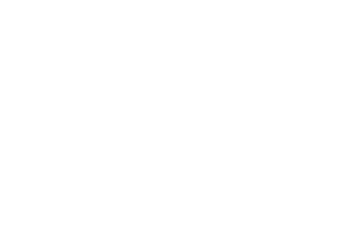

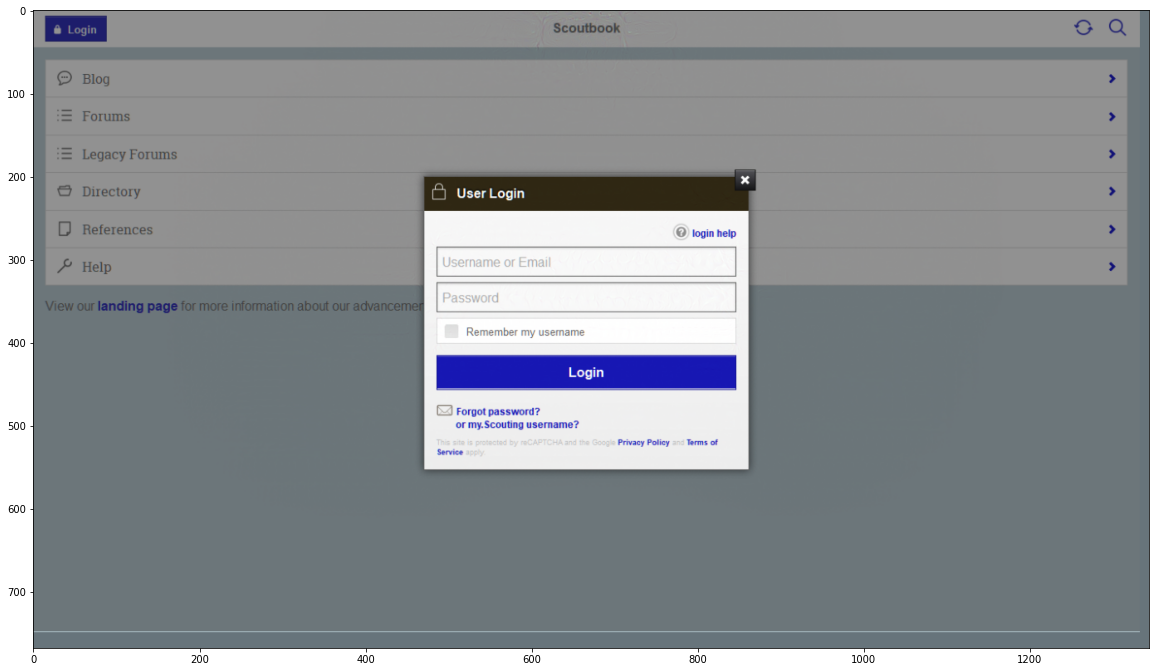

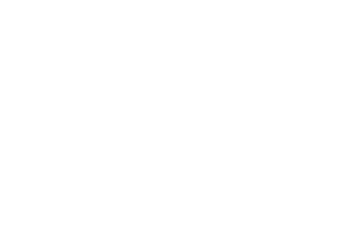

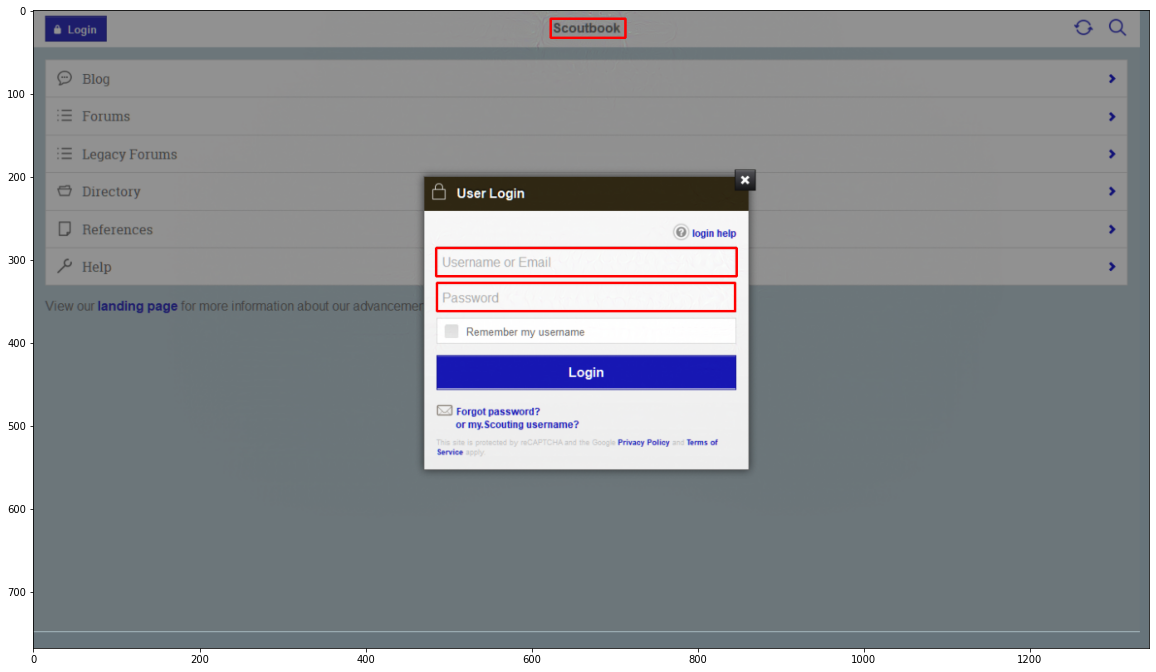

In [46]:
visualize(coco_mix, coco_mix.getImgIds(), figsize=(20,20))